In [17]:
import matplotlib.pyplot as plt
import mpl_lego as mplego
import numpy as np
import pandas as pd
import seaborn as sns

from functools import partial
from mpl_lego.labels import bold_text, apply_subplot_labels
from scipy.stats import bootstrap
from pyprojroot import here
from sklearn.metrics import f1_score

from moral_foundations_llms import keys
 
%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', 0)

In [3]:
mplego.style.use_latex_style()

In [4]:
df = pd.read_csv(here('data/aita_final_v15.csv'))

/var/folders/6h/ms_dpkl536d1w6qqd_wnckrw0000gn/T/ipykernel_4748/2259072775.py:1: DtypeWarning: Columns (29,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(here('data/aita_final_v15.csv'))


In [27]:
f1_score(df[keys.MORAL_LABELS_COLS].values, df[keys.MORAL_MODEL_LABEL_COLS[model]].values, average='weighted')

0.7755712449382679

In [23]:
df[keys.MORAL_LABELS_COLS].sum(axis=1).mean()

2.7566044707186403

In [30]:
for model in keys.MODELS:
    print(model)
    print("f1 score:", f1_score(df[keys.MORAL_LABELS_COLS].values, df[keys.MORAL_MODEL_LABEL_COLS[model]].values, average='weighted'))
    #print("Average moral overlap:", (df[keys.MORAL_LABELS_COLS].values == df[keys.MORAL_MODEL_LABEL_COLS[model]].values).sum(axis=1).mean())
    #print("Moral overlap stdev", (df[keys.MORAL_LABELS_COLS].values == df[keys.MORAL_MODEL_LABEL_COLS[model]].values).sum(axis=1).var())
    #print("Avg number of moral labels", df[keys.MORAL_MODEL_LABEL_COLS[model]].sum(axis=1).mean())

reddit
f1 score: 0.714981189348161
gpt3.5
f1 score: 0.7795719167114441
gpt4
f1 score: 0.7827499093147233
claude
f1 score: 0.7999644962695334
bison
f1 score: 0.7608408920301514
gemma
f1 score: 0.7655414548745177
mistral
f1 score: 0.7609656766381862
llama
f1 score: 0.7755712449382679


In [5]:
# Calculate bootstrap estimates
def label_difference(records, scenario, model_name, label):
    scenarios = records[scenario]
    verdicts = records[model_name]
    diff = (verdicts[scenarios == True] == label).mean() - (verdicts[scenarios == False] == label).mean()
    return diff

In [37]:
def diff_calc(df, model, model_label_col, model_moral_label):
    true = df[df[model_moral_label]][model_label_col].copy()
    false = df[~df[model_moral_label]][model_label_col].copy()

    true_counts = true.value_counts(normalize=True)
    false_counts = false.value_counts(normalize=True)


    if 'NTA' not in true_counts:
        true_counts['NTA'] = 0
    if 'NAH' not in true_counts:
        true_counts['NAH'] = 0
    if 'NTA' not in false_counts:
        true_counts['NTA'] = 0
    if 'NAH' not in false_counts:
        false_counts['NAH'] = 0 

    diff = true_counts.loc[['NTA', 'YTA', 'NAH', 'ESH']] - false_counts.loc[['NTA', 'YTA', 'NAH', 'ESH']]
    return diff

In [39]:
diffs = np.zeros((keys.n_models, keys.n_morals, len(keys.AITA_LABELS) - 1))

for ii, ((model, model_moral_label_cols), model_label_col), in enumerate(zip(keys.MORAL_MODEL_LABEL_DICT.items(), keys.LABEL_COLS)):
    for jj, model_moral_label_col in enumerate(model_moral_label_cols):
        diffs[ii, jj] = 100 * diff_calc(df, model, model_label_col, model_moral_label_col)

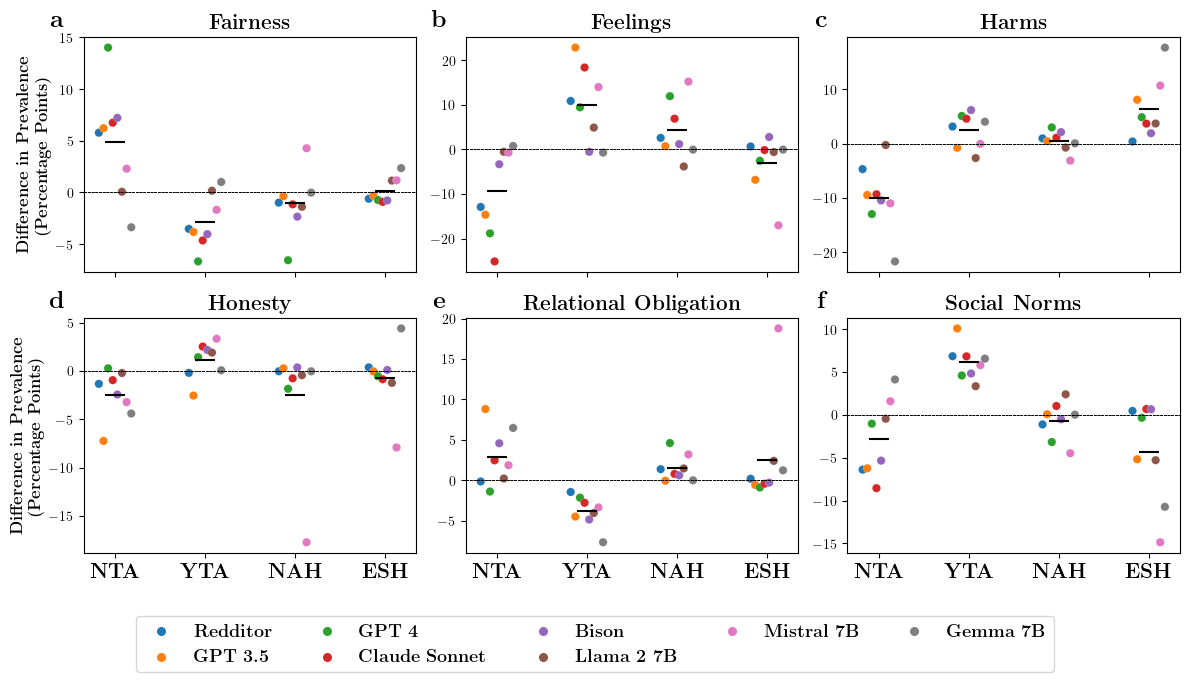

In [51]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True)

rng = np.random.default_rng(2332)
# jitter = rng.normal(scale=0.08, size=keys.n_models)

jitter = np.linspace(-0.18, 0.18, keys.n_models) 

for ii, ax in enumerate(axes.ravel()):
    for jj in range(4):
        vals = diffs[:, ii, jj]
        ax.scatter(np.tile(jj, keys.n_models) + jitter,
                   diffs[:, ii, jj],
                   edgecolor='white',
                   linewidth=0.1,
                   color=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'])
        ax.scatter(jj, vals.mean(), marker='_', s=200, color='black')
        ax.axhline(0, linewidth=0.5, linestyle='--', color='black')
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(bold_text(['NTA', 'YTA', 'NAH', 'ESH']), fontsize=15)
    ax.set_title(bold_text(keys.MORAL_AXES_LABELS_PLOT[ii]), fontsize=15)

for ax in axes[:, 0]:
    ax.set_ylabel(bold_text('Difference in Prevalence\n(Percentage Points)'), fontsize=12)

xlim = axes[0, 0].get_xlim()

for idx, (model, model_label) in enumerate(zip(keys.MODELS, keys.MODEL_LABELS_PLOT)):
    ax.scatter(-1, 0, color=f'C{idx}', label=bold_text(model_label), s=30)

fig.legend(
    loc='center', bbox_to_anchor=(0.5, -0.08), prop={'size': 13}, ncol=5)

axes[-1, -1].set_xlim(xlim)

apply_subplot_labels(axes, bold=True, size=18, x=-0.08, y=1.07)


plt.tight_layout()
plt.savefig('model_label_reasons.pdf', bbox_inches='tight')